In [1]:
import numpy as np 
import pandas as pd
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from scipy import special
from tqdm import tqdm
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, classification_report


warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)


In [2]:
X_train = pd.read_csv('D:\JAIN-WIN\Archive\X_train_large.csv')
y_train = pd.read_csv('D:\JAIN-WIN\Archive\y_train_large.csv').squeeze()
X_test = pd.read_csv('D:\JAIN-WIN\Archive\X_test_large.csv')
y_test = pd.read_csv('D:\JAIN-WIN\Archive\y_test_large.csv').squeeze()

<>:1: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:3: SyntaxWarning: invalid escape sequence '\J'
<>:4: SyntaxWarning: invalid escape sequence '\J'
<>:1: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:3: SyntaxWarning: invalid escape sequence '\J'
<>:4: SyntaxWarning: invalid escape sequence '\J'
C:\Users\User\AppData\Local\Temp\ipykernel_21032\3179553642.py:1: SyntaxWarning: invalid escape sequence '\J'
  X_train = pd.read_csv('D:\JAIN-WIN\Archive\X_train_large.csv')
C:\Users\User\AppData\Local\Temp\ipykernel_21032\3179553642.py:2: SyntaxWarning: invalid escape sequence '\J'
  y_train = pd.read_csv('D:\JAIN-WIN\Archive\y_train_large.csv').squeeze()
C:\Users\User\AppData\Local\Temp\ipykernel_21032\3179553642.py:3: SyntaxWarning: invalid escape sequence '\J'
  X_test = pd.read_csv('D:\JAIN-WIN\Archive\X_test_large.csv')
C:\Users\User\AppData\Local\Temp\ipykernel_21032\3179553642.py:4: S

In [3]:
X_train.head()

,age,bmi,elective_surgery,gender,height,icu_id,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,icu_id_counts,age_counts,nan_counts,sq_age,sq_bmi,bmi_age,weight_age,comorbidity_score,diabete_risk,gcs_sum,apache_2_diagnosis_type,apache_3j_diagnosis_type,bmi_type,height_type,weight_type,age_type,gcs_sum_type,apache_3j_diagnosis_x,apache_2_diagnosis_x,apache_3j_diagnosis_split1,apache_2_diagnosis_split1,profile,diff_bmi,dailyLabs_row_nan_count,hourlyLabs_row_nan_count,diff_labTestsRun_daily_hourly,bilirubin_nans,bilirubin_d1_h1_max_eq,bilirubin_d1_h1_min_eq,bilirubin_h1_value_range,bilirubin_h1_zero_range,bilirubin_h1_mean,bilirubin_h1_std,bilirubin_h1_max_apache_3j_diagnosis_mean,bilirubin_h1_max_apache_3j_diagnosis_diff,bilirubin_h1_max_apache_3j_diagnosis_std,bilirubin_h1_max_apache_3j_diagnosis_norm_std,bilirubin_h1_max_apache_3j_diagnosis_rank,bilirubin_h1_max_apache_3j_diagnosis_count,bilirubin_h1_max_apache_3j_diagnosis_norm_rank,bilirubin_h1_max_apache_3j_diagnosis_skew,bilirubin_h1_min_apache_3j_diagnosis_mean,bilirubin_h1_min_apache_3j_diagnosis_diff,bilirubin_h1_min_apache_3j_diagnosis_std,bilirubin_h1_min_apache_3j_diagnosis_norm_std,bilirubin_h1_min_apache_3j_diagnosis_rank,bilirubin_h1_min_apache_3j_diagnosis_count,bilirubin_h1_min_apache_3j_diagnosis_norm_rank,bilirubin_h1_min_apache_

In [4]:
print(f"Initial Training Features: {X_train.shape}")
print(f"Initial Testing Features: {X_test.shape}")

Initial Training Features: (91109, 4332)
Initial Testing Features: (39048, 4332)


In [5]:
def evaluate_lightgbm(X_train, y_train, X_test, y_test):
    """
    Returns:
    - model (lgb.LGBMClassifier): Trained LightGBM model.
    - roc_auc (float): ROC-AUC score on the test set.
    - report (str): Classification report with precision, recall, and F1-score up to 4 decimals.
    """
    # Initialize the LightGBM classifier with default parameters
    model = lgb.LGBMClassifier(
        random_state=69,        # For reproducibility
        n_jobs=-1,
        force_col_wise=True              # Utilize all available cores
    )
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Predict probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Predict class labels
    y_pred = model.predict(X_test)
    
    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Generate classification report with 4 decimal places
    report = classification_report(y_test, y_pred, digits=4)
    
    # Print the evaluation metrics
    print(f"ROC-AUC: {roc_auc:.8f}")
    print("Classification Report:\n", report)
    
    return model, roc_auc, report

In [6]:
from sklearn.feature_selection import VarianceThreshold

def variance_thresholding(X_train, X_test, threshold=0.01):
    
    print(f"\nApplying Variance Thresholding with threshold={threshold}...")
    
    # Initialize the VarianceThreshold selector
    selector = VarianceThreshold(threshold=threshold)
    
    # Fit the selector on the training data
    selector.fit(X_train)
    
    # Get the boolean mask of selected features
    mask = selector.get_support()
    
    # Extract the selected feature names
    selected_features = X_train.columns[mask].tolist()
    
    # Calculate number of features removed
    num_features_removed = X_train.shape[1] - len(selected_features)
    
    print(f"Variance Thresholding: Removed {num_features_removed} features.")
    print(f"Number of features before: {X_train.shape[1]}")
    print(f"Number of features after: {len(selected_features)}")
    
    # Transform both training and testing data
    X_train_reduced = X_train[selected_features]
    X_test_reduced = X_test[selected_features]
    
    return X_train_reduced, X_test_reduced, selected_features


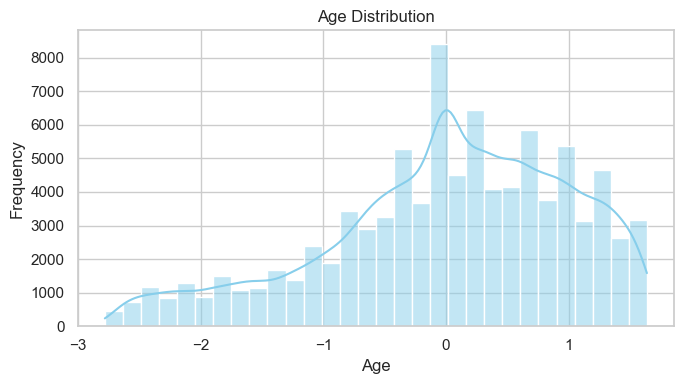

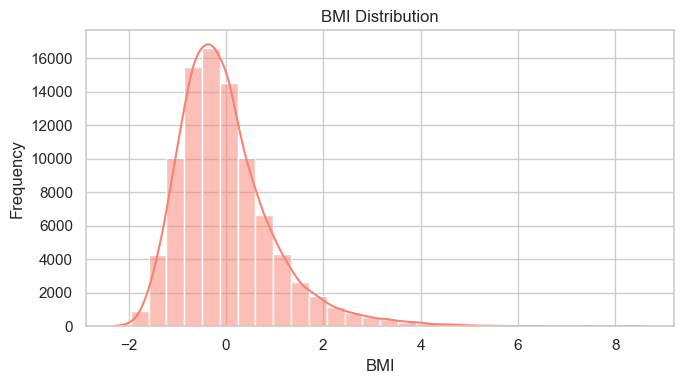

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Age Distribution
plt.figure(figsize=(7, 4))
sns.histplot(X_train['age'], bins=30, kde=True, color='skyblue')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
# plt.savefig("figures/age_distribution.png", dpi=300)
plt.show()

# BMI Distribution
plt.figure(figsize=(7, 4))
sns.histplot(X_train['bmi'], bins=30, kde=True, color='salmon')
plt.title("BMI Distribution")
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.tight_layout()
# plt.savefig("figures/bmi_distribution.png", dpi=300)
plt.show()


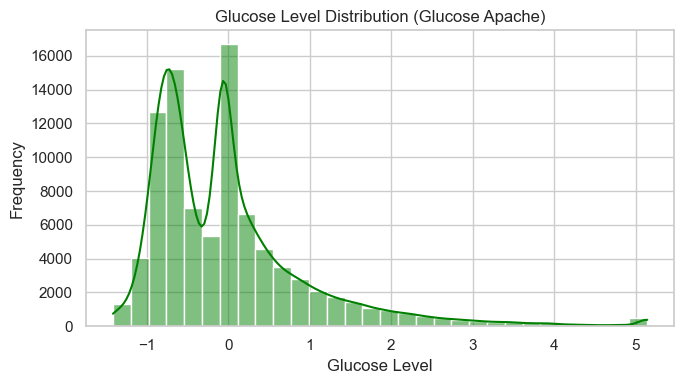

In [8]:
# Glucose if available
if 'glucose_apache' in X_train.columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(X_train['glucose_apache'], bins=30, kde=True, color='green')
    plt.title("Glucose Level Distribution (Glucose Apache)")
    plt.xlabel("Glucose Level")
    plt.ylabel("Frequency")
    plt.tight_layout()
    # plt.savefig("figures/glucose_distribution.png", dpi=300)
    plt.show()


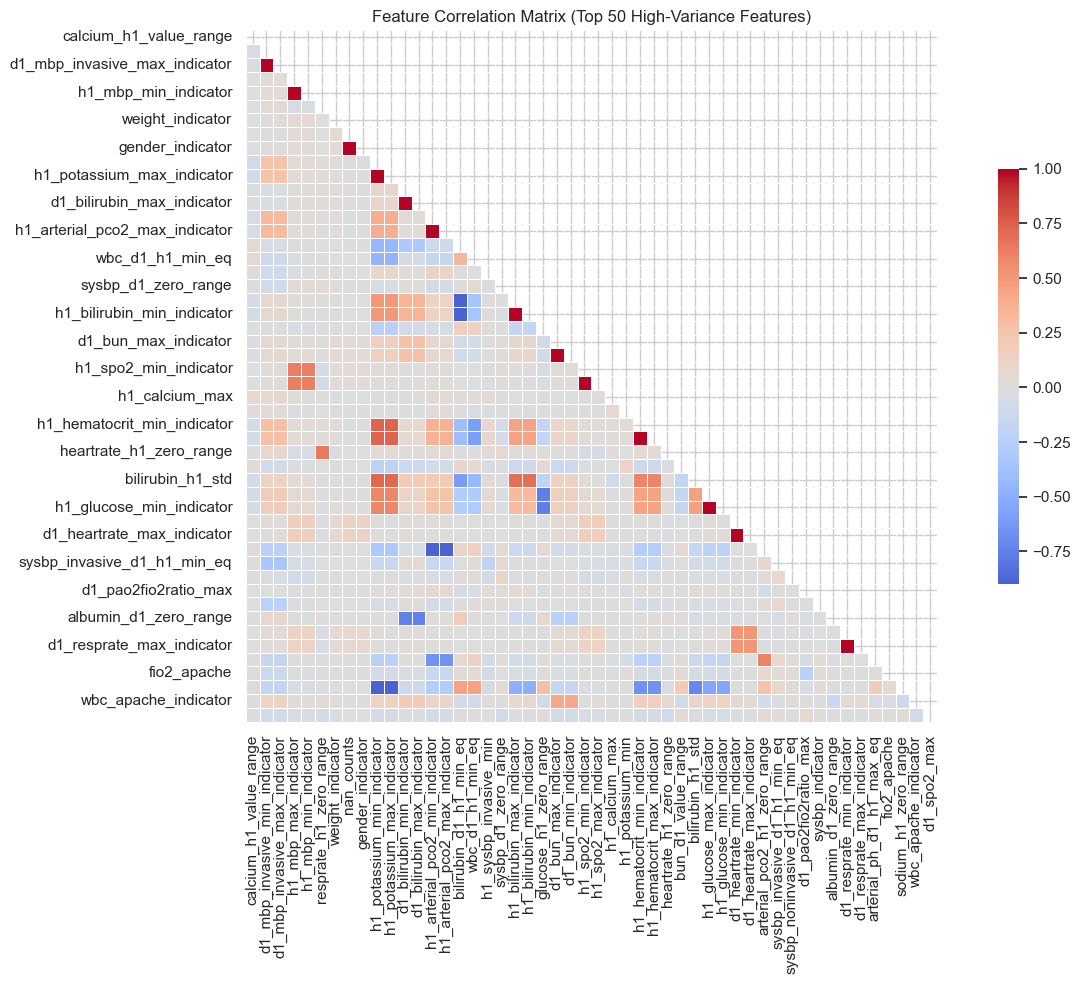

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select top N features with highest variance (to keep plot readable)
numeric_data = X_train.select_dtypes(include=['float64', 'int64'])
top_vars = numeric_data.var().sort_values(ascending=False).head(50).index
corr_matrix = numeric_data[top_vars].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

# Draw the heatmap
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .6},
            annot=False)

plt.title("Feature Correlation Matrix (Top 50 High-Variance Features)")
plt.tight_layout()
# plt.savefig("figures/correlation_heatmap_top50.png", dpi=300)
plt.show()


In [10]:
pip install sklearn.inspection

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sklearn.inspection (from versions: none)
ERROR: No matching distribution found for sklearn.inspection


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

# Train model (or use LightGBM, xgboost, etc. as long as it's sklearn-compatible)
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Features to include in PDP
features = [
    'age', 'bmi', 'glucose_apache', 'apache_2_diagnosis', 
    'creatinine_apache', 'bun_apache', 'weight', 'gcs_sum'
]

# Plot all at once (auto-grid)
fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(model, X_train, features=features, ax=ax)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt



# ✅ Most relevant features from your dataset (customize as needed)
features_1d = [
    'age', 'bmi', 'glucose_apache', 'apache_2_diagnosis',
    'creatinine_apache', 'bun_apache', 'weight', 'gcs_sum'
]

# ✅ Plot all 1D PDPs (standard layout)
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))  # 8 features -> 4x2 grid
PartialDependenceDisplay.from_estimator(model, X_train, features=features_1d, ax=ax)
plt.suptitle("Partial Dependence Plots (1D)", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


In [ ]:
# Example: interaction between 'age' and 'bmi'
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    features=[('age', 'bmi')],
    kind="average",  # or "individual" for ICE
    grid_resolution=30
)
plt.title("2D Partial Dependence: Age vs BMI")
plt.tight_layout()
plt.show()


In [11]:
X_train_vt, X_test_vt, vt_selected_features = variance_thresholding(X_train, X_test, threshold=0.1)
print("Results at threshhold 0.1")
model_miano, auc_miano, report_miano = evaluate_lightgbm(X_train_vt, y_train, X_test_vt, y_test)


Applying Variance Thresholding with threshold=0.1...
Variance Thresholding: Removed 123 features.
Number of features before: 4332
Number of features after: 4209
Results at threshhold 0.1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Total Bins 928739
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 4209
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
ROC-AUC: 0.87206368
Classification Report:
               precision    recall  f1-score   support

         0.0     0.8718    0.9385    0.9039     30574
         1.0     0.6934    0.5020    0.5824      8474

    accuracy                         0.8438     39048
   macro avg     0.7826    0.7202    0.7431     39048
weighted avg     0.8331    0.8438    0.8341     39048



In [12]:
X_train=X_train_vt
X_test=X_test_vt

In [ ]:
import pandas as pd
import numpy as np

thresholds = [0.98,0.99,0.995, 0.999, 0.9995]

# Dictionary to store the number of features removed for each threshold
features_removed = {}

# Dictionary to store ROC-AUC scores for each threshold
auc_scores = {}

# Initialize variables to track the best threshold and corresponding datasets
best_auc = 0
best_threshold = None
best_X_train_dropped = None
best_X_test_dropped = None

# Calculate the absolute correlation matrix once
print("Calculating the correlation matrix...")
corr_matrix = X_train.corr().abs()

# Select the upper triangle of the correlation matrix to avoid duplicate pairs
print("Selecting the upper triangle of the correlation matrix...")
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Iterate through each threshold
for threshold in thresholds:
    print(f"\nProcessing threshold: {threshold}")
    
    # Identify features to drop: any feature with correlation > threshold in the upper triangle
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop the identified features from both training and testing sets
    X_train_dropped = X_train.drop(columns=to_drop)
    X_test_dropped = X_test.drop(columns=to_drop)
    
    # Store the number of features removed
    features_removed[threshold] = len(to_drop)
    
    print(f"Threshold: {threshold}")
    print(f"Number of features removed: {len(to_drop)}")
    print(f"Number of features after removal: {X_train_dropped.shape[1]}")
    
    # Train and evaluate the model using the dropped feature set
    print("Training and evaluating the model...")
    model, auc, report = evaluate_lightgbm(X_train_dropped, y_train, X_test_dropped, y_test)
    
    # Store the ROC-AUC score
    auc_scores[threshold] = auc
    print(f"ROC-AUC for threshold {threshold}: {auc:.4f}")
    
    # Update the best threshold if current AUC is better
    if auc > best_auc:
        best_auc = auc
        best_threshold = threshold
        best_X_train_dropped = X_train_dropped.copy()
        best_X_test_dropped = X_test_dropped.copy()




Calculating the correlation matrix...


In [11]:
import pandas as pd
import numpy as np

thresholds = [0.9999,0.99995,0.99999]

# Iterate through each threshold
for threshold in thresholds:
    print(f"\nProcessing threshold: {threshold}")
    
    # Identify features to drop: any feature with correlation > threshold in the upper triangle
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop the identified features from both training and testing sets
    X_train_dropped = X_train.drop(columns=to_drop)
    X_test_dropped = X_test.drop(columns=to_drop)
    
    # Store the number of features removed
    features_removed[threshold] = len(to_drop)
    
    print(f"Threshold: {threshold}")
    print(f"Number of features removed: {len(to_drop)}")
    print(f"Number of features after removal: {X_train_dropped.shape[1]}")
    
    # Train and evaluate the model using the dropped feature set
    print("Training and evaluating the model...")
    model, auc, report = evaluate_lightgbm(X_train_dropped, y_train, X_test_dropped, y_test)
    
    # Store the ROC-AUC score
    auc_scores[threshold] = auc
    print(f"ROC-AUC for threshold {threshold}: {auc:.4f}")
    
    # Update the best threshold if current AUC is better
    if auc > best_auc:
        best_auc = auc
        best_threshold = threshold
        best_X_train_dropped = X_train_dropped.copy()
        best_X_test_dropped = X_test_dropped.copy()


Processing threshold: 0.9999
Threshold: 0.9999
Number of features removed: 511
Number of features after removal: 3698
Training and evaluating the model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Total Bins 850113
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 3698
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
ROC-AUC: 0.87206368
Classification Report:
               precision    recall  f1-score   support

         0.0     0.8718    0.9385    0.9039     30574
         1.0     0.6934    0.5020    0.5824      8474

    accuracy                         0.8438     39048
   macro avg     0.7826    0.7202    0.7431     39048
weighted avg     0.8331    0.8438    0.8341     39048

ROC-AUC for threshold 0.9999: 0.8721

Processing threshol

In [12]:
import pandas as pd
import numpy as np

thresholds = [0.999995,0.999999,0.9999999]

# Iterate through each threshold
for threshold in thresholds:
    print(f"\nProcessing threshold: {threshold}")
    
    # Identify features to drop: any feature with correlation > threshold in the upper triangle
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop the identified features from both training and testing sets
    X_train_dropped = X_train.drop(columns=to_drop)
    X_test_dropped = X_test.drop(columns=to_drop)
    
    # Store the number of features removed
    features_removed[threshold] = len(to_drop)
    
    print(f"Threshold: {threshold}")
    print(f"Number of features removed: {len(to_drop)}")
    print(f"Number of features after removal: {X_train_dropped.shape[1]}")
    
    # Train and evaluate the model using the dropped feature set
    print("Training and evaluating the model...")
    model, auc, report = evaluate_lightgbm(X_train_dropped, y_train, X_test_dropped, y_test)
    
    # Store the ROC-AUC score
    auc_scores[threshold] = auc
    print(f"ROC-AUC for threshold {threshold}: {auc:.4f}")
    
    # Update the best threshold if current AUC is better
    if auc > best_auc:
        best_auc = auc
        best_threshold = threshold
        best_X_train_dropped = X_train_dropped.copy()
        best_X_test_dropped = X_test_dropped.copy()


Processing threshold: 0.999995
Threshold: 0.999995
Number of features removed: 503
Number of features after removal: 3706
Training and evaluating the model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Total Bins 851737
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 3706
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
ROC-AUC: 0.87206368
Classification Report:
               precision    recall  f1-score   support

         0.0     0.8718    0.9385    0.9039     30574
         1.0     0.6934    0.5020    0.5824      8474

    accuracy                         0.8438     39048
   macro avg     0.7826    0.7202    0.7431     39048
weighted avg     0.8331    0.8438    0.8341     39048

ROC-AUC for threshold 0.999995: 0.8721

Processing th

In [13]:
import pandas as pd
import numpy as np

thresholds = [0.9999999999999,0.99999999999999,0.999999999999999,0.9999999999999999,0.99999999999999999,0.999999999999999999]

# Iterate through each threshold
for threshold in thresholds:
    print(f"\nProcessing threshold: {threshold}")
    
    # Identify features to drop: any feature with correlation > threshold in the upper triangle
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop the identified features from both training and testing sets
    X_train_dropped = X_train.drop(columns=to_drop)
    X_test_dropped = X_test.drop(columns=to_drop)
    
    # Store the number of features removed
    features_removed[threshold] = len(to_drop)
    
    print(f"Threshold: {threshold}")
    print(f"Number of features removed: {len(to_drop)}")
    print(f"Number of features after removal: {X_train_dropped.shape[1]}")
    
    # # Train and evaluate the model using the dropped feature set
    # print("Training and evaluating the model...")
    # model, auc, report = evaluate_lightgbm(X_train_dropped, y_train, X_test_dropped, y_test)
    
    # # Store the ROC-AUC score
    # auc_scores[threshold] = auc
    # print(f"ROC-AUC for threshold {threshold}: {auc:.4f}")
    
    # # Update the best threshold if current AUC is better
    # if auc > best_auc:
    #     best_auc = auc
    #     best_threshold = threshold
    #     best_X_train_dropped = X_train_dropped.copy()
    #     best_X_test_dropped = X_test_dropped.copy()


Processing threshold: 0.9999999999999


NameError: name 'upper' is not defined

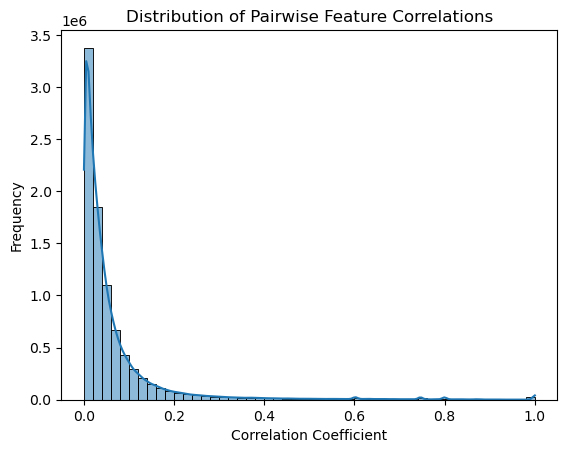

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
# Unstack and drop NaNs
correlations = upper.unstack().dropna()

# Plot the distribution
sns.histplot(correlations, bins=50, kde=True)
plt.title('Distribution of Pairwise Feature Correlations')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()

In [16]:
import pandas as pd
import numpy as np

thresholds = [0.9999]

# Dictionary to store the number of features removed for each threshold
features_removed = {}

# Dictionary to store ROC-AUC scores for each threshold
auc_scores = {}

# Initialize variables to track the best threshold and corresponding datasets
best_auc = 0
best_threshold = None
best_X_train_dropped = None
best_X_test_dropped = None

# Iterate through each threshold
for threshold in thresholds:
    print(f"\nProcessing threshold: {threshold}")
    
    # Identify features to drop: any feature with correlation > threshold in the upper triangle
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop the identified features from both training and testing sets
    X_train_dropped = X_train.drop(columns=to_drop)
    X_test_dropped = X_test.drop(columns=to_drop)
    
    # Store the number of features removed
    features_removed[threshold] = len(to_drop)
    
    print(f"Threshold: {threshold}")
    print(f"Number of features removed: {len(to_drop)}")
    print(f"Number of features after removal: {X_train_dropped.shape[1]}")
    
    # Train and evaluate the model using the dropped feature set
    print("Training and evaluating the model...")
    model, auc, report = evaluate_lightgbm(X_train_dropped, y_train, X_test_dropped, y_test)
    
    # Store the ROC-AUC score
    auc_scores[threshold] = auc
    print(f"ROC-AUC for threshold {threshold}: {auc:.4f}")
    
    # Update the best threshold if current AUC is better
    if auc > best_auc:
        best_auc = auc
        best_threshold = threshold
        best_X_train_dropped = X_train_dropped.copy()
        best_X_test_dropped = X_test_dropped.copy()


Processing threshold: 0.9999
Threshold: 0.9999
Number of features removed: 511
Number of features after removal: 3698
Training and evaluating the model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Total Bins 850113
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 3698
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
ROC-AUC: 0.87206368
Classification Report:
               precision    recall  f1-score   support

         0.0     0.8718    0.9385    0.9039     30574
         1.0     0.6934    0.5020    0.5824      8474

    accuracy                         0.8438     39048
   macro avg     0.7826    0.7202    0.7431     39048
weighted avg     0.8331    0.8438    0.8341     39048

ROC-AUC for threshold 0.9999: 0.8721


In [18]:
if best_threshold is not None:
    print(f"\nBest Threshold: {best_threshold} with ROC-AUC: {best_auc:.4f}")

    
    best_X_train_dropped.to_csv("X_train_corr.csv", index=False)
    best_X_test_dropped.to_csv("X_test_corr.csv", index=False)
    
    print(f"Saved the best feature sets to")
else:
    print("No improvement in ROC-AUC was observed across the thresholds.")


Best Threshold: 0.9999 with ROC-AUC: 0.8721
Saved the best feature sets to
